This work utilizes a dataset created by the Energy Data Analytics Lab at Duke University. The dataset contains geospatial data and border vertices for over 19,000 solar panels, located in the California cities of Fresno, Stockton, Oxnard, and Modesto. The full dataset of images and annotations can be found [here](https://figshare.com/collections/Full_Collection_Distributed_Solar_Photovoltaic_Array_Location_and_Extent_Data_Set_for_Remote_Sensing_Object_Identification/3255643/3).

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from skimage import io
import matplotlib.cm as cm
from matplotlib.patches import Circle, Polygon

#Importing raw data from the CSV files.
pv_arrays = pd.read_csv("version1\polygonDataExceptVertices.csv")
vertices = pd.read_csv("version1\polygonVertices_PixelCoordinates.csv")

print(pv_arrays.shape)
print(vertices.shape)


(19863, 17)
(19863, 294)


Description of the columns:

polygon_id -> Each PV array corresponds to a polygon

centroid_latitude/centroid_longitude -> latitude and longitude of the centroid of the polygon

centroid_latitude_pixels/centroid_longitude_pixels -> pixel co-ordinates of the centroid of the polygon

city -> location of the PV array

area_pixels -> ?

area_meters -> ?

image_name -> image containing the PV array

nw_corner_of_image_latitude/nw_corner_of_image_longitude/se_corner_of_image_latitude/se_corner_of_image_longitude -> latitudes 
and longitudes of the corners of the image.

datum -> ? (not used)

projection_zone -> ? (not used)

resolution -> meters per pixel

jaccard_index -> ? (not used)

NOTE: Somehow area_meters and area_pixels are related, as area_meters divided by area_pixels ~ 11.1 for all polygons 

In [99]:
pv_arrays.head()

,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index
0,1,36.926055,-119.840241,107.618458,3286.151487,Fresno,136.192872,1513.254134,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.914020
1,2,36.926217,-119.840241,45.977659,3286.352946,Fresno,155.511714,1727.907934,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.829071
2,3,36.926277,-119.840174,22.280851,3303.465657,Fresno,111.796591,1242.184349,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.937961
3,4,36.920969,-119.842798,2048.362567,2547.366116,Fresno,62.004008,688.933420,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.842634
4,5,36.920938,-119.842859,2060.014890,2529.504997,Fresno,95.480150,1060.890554,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.890998


In [100]:
vertices.head()

,dataPolygonsPixels1,dataPolygonsPixels2,dataPolygonsPixels3_ 1,dataPolygonsPixels3_ 2,dataPolygonsPixels3_ 3,dataPolygonsPixels3_ 4,dataPolygonsPixels3_ 5,dataPolygonsPixels3_ 6,dataPolygonsPixels3_ 7,dataPolygonsPixels3_ 8,...,dataPolygonsPixels3_283,dataPolygonsPixels3_284,dataPolygonsPixels3_285,dataPolygonsPixels3_286,dataPolygonsPixels3_287,dataPolygonsPixels3_288,dataPolygonsPixels3_289,dataPolygonsPixels3_290,dataPolygonsPixels3_291,dataPolygonsPixels3_292
0,1,8,131.631164,3360.495069,87.985141,3249.197710,73.850000,3213.750000,81.950000,3210.450000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,9,69.615385,3361.153846,12.846154,3217.615385,13.096107,3217.440417,12.450000,3215.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11,48.136863,3358.015726,48.150000,3358.050000,42.379290,3360.742998,39.467456,3362.122288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,9,2068.049310,2571.591716,2067.393899,2571.021266,2067.150000,2571.350000,2021.550000,2531.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9,2091.398422,2563.781065,2021.674556,2504.416174,2022.048728,2503.979640,2021.550000,2503.550000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see above, the 'polygonVertices_PixelCoordinates.csv' file contains the vertice co-ordinates of each of the vertices for a given polygon. This however has to be cleaned to get the co-ordinates of the vertices in (x,y) format.

In [101]:
flat = pd.melt(vertices, id_vars=['dataPolygonsPixels1','dataPolygonsPixels2'])#Melting the data to have just the first two columns
flat = flat.dropna() #drop rows with empty values
#flat['value'] = flat['value'].map(lambda x: int(round(x))) #Rounding the pixel values of the vertices
flat['pixel_id'] = flat['variable'].map(lambda x: int(x.replace(' ','').split('_')[1])) #Extract the pixel id from the column name
flat.drop('variable', axis=1, inplace=True)  
pair1 = zip(range(1,292,2), range(2,293,2)) # Creating iterators (1,2),(3,4),(5,6) ....(291,292) for each each vertex pixel co-ordinates
pair2 = zip(range(1,292,2), range(2,293,2)) 
pairs = [pair for double in zip(pair1, pair2) for pair in double]# Since we have 292 pixel id's corresponding to 146 vertices - each pixel id must have the right pair. So we need 292 pairs... (1,2)(1,2)(3,4)(3,4)...(291,292)(291,292)    
flat['pair'] = flat['pixel_id'].map(lambda x: pairs[x - 1])# Assign the correct pairs for each pixel
even = flat[(flat['pixel_id'] % 2 == 0)] #Even pixel ids
odd = flat[~(flat['pixel_id'] % 2 == 0)] #Odd pixel ids
flat_merge = odd.merge(even, on=['dataPolygonsPixels1','dataPolygonsPixels2','pair'])#Merging the values on polygonId and Vertices
flat_merge['coordinate'] = map(lambda x, y: (x, y), flat_merge['value_x'].values, flat_merge['value_y'].values)#creating a coordinate column  
polygon_vertices = flat_merge[['dataPolygonsPixels1','coordinate']] #recombining all coordinate pairs by polygon id
polygon_vertices = pd.pivot_table(polygon_vertices, index='dataPolygonsPixels1', values='coordinate',
                                 aggfunc=lambda x: x.values.tolist())#Creating a dataframe with polygon id as index and combining all the acoordinates of its vertices 
polygon_vertices = polygon_vertices.reset_index() #restore to previous index
polygon_vertices.columns = ['polygon_id','polygon_vertices'] #Renaming the columns


Now we need to merge this into the pv_arrays dataframe.

In [102]:
pv_arrays_clean = pv_arrays.merge(polygon_vertices, how='inner', on='polygon_id')
pv_arrays_clean = pv_arrays_clean[['polygon_id', 'centroid_latitude_pixels', 'centroid_longitude_pixels', 'city','area_pixels','area_meters', 
                            'image_name', 'polygon_vertices']]
pv_arrays_clean.head()

,polygon_id,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,polygon_vertices
0,1,107.618458,3286.151487,Fresno,136.192872,1513.254134,11ska460890,"[<map object at 0x000002521C0DE400>, <map obje..."
1,2,45.977659,3286.352946,Fresno,155.511714,1727.907934,11ska460890,"[<map object at 0x000002521C0DE400>, <map obje..."
2,3,22.280851,3303.465657,Fresno,111.796591,1242.184349,11ska460890,"[<map object at 0x000002521C0DE400>, <map obje..."
3,4,2048.362567,2547.366116,Fresno,62.004008,688.933420,11ska460890,"[<map object at 0x000002521C0DE400>, <map obje..."
4,5,2060.014890,2529.504997,Fresno,95.480150,1060.890554,11ska460890,"[<map object at 0x000002521C0DE400>, <map obje..."


In [103]:
pv_arrays_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19863 entries, 0 to 19862
Data columns (total 8 columns):
polygon_id                   19863 non-null int64
centroid_latitude_pixels     19861 non-null float64
centroid_longitude_pixels    19861 non-null float64
city                         19863 non-null object
area_pixels                  19863 non-null float64
area_meters                  19863 non-null float64
image_name                   19863 non-null object
polygon_vertices             19863 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 1.4+ MB


Exploratory Data Analysis.

Number of array annotations and satellite images for each city.


In [104]:
poly_agg = pv_arrays_clean.groupby(['city','image_name'])[['polygon_id']].count().reset_index() #Number of polygons per image 
pv_array_agg = poly_agg.groupby('city')[['image_name']].count().reset_index() #Number of images per city 
pv_array_agg = pv_array_agg.merge(poly_agg.groupby('city')[['polygon_id']].sum().reset_index())#Number of polygons per city
pv_array_agg

,city,image_name,polygon_id
0,Fresno,312,14803
1,Modesto,19,613
2,Oxnard,52,1765
3,Stockton,85,2682


Since Fresno data is very big, we use the images from other other 3 cities (Modesto, Oxnard, Stockton) for the initial analysis.

In [105]:
 
# Different cities
cities = pv_array_agg['city'].unique()


In [106]:
# Reading in the number of available images in the dataset
avail_files = []

for city in cities: 
    path ='C:/Users/kaush/Documents/Dataset/%s'%(city)
    try:
        avail_files.extend(listdir(path))
    except:
        continue
#Stores all the image files in the
avail_files = [name[:-4] for name in avail_files if name[-4:] == '.tif']

In [110]:
avail_arrays = pv_arrays_clean[pv_arrays_clean['image_name'].isin(avail_files)]#Make an array of actually available images
#plotting the number of images and polygon ids available in each array
avail_poly_agg = avail_arrays.groupby(['city','image_name'])[['polygon_id']].count().reset_index()
avail_array_agg = avail_poly_agg.groupby('city')[['image_name']].count().reset_index()
avail_array_agg = avail_array_agg.merge(avail_poly_agg.groupby('city')[['polygon_id']].sum().reset_index())
#avail_array_agg = avail_array_agg.sort_values(by='image_name', ascending=False)
avail_array_agg

,city,image_name,polygon_id
0,Modesto,19,613
1,Oxnard,52,1765
2,Stockton,85,2682


Images are 5000*5000 pixels-  RGB. 

In [111]:
# Plot centers of all solar arrays for a given satellite image

def plot_centroids(img_id):
    
    # Use img_id to get the city name from the CSV file 
    city = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['city'].values[0]
    
    # Read in image
    img = io.imread('C:/Users/kaush/Documents/Dataset/%s/%s.tif' % (city, img_id))
    
    # Extract centroid coordinates from dataframe   
    arrays_sub = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id] #Create a dataframe containing only entries (polygon ids) corresponding to this img_id
    
    #Obtain the coordinates for the centroid.
    coordinates = zip(list(arrays_sub['centroid_longitude_pixels']),
                      list(arrays_sub['centroid_latitude_pixels']))

    # Display image
    fig,ax = plt.subplots(figsize=(12, 12))

    ax.imshow(img[:,:,1], cmap=cm.gray)
    
    # Plot a circle for each solar panel array
    for x, y in coordinates:
        centroid = Circle((x, y), 20, color='blue')
        ax.add_patch(centroid)

(5000, 5000, 3)


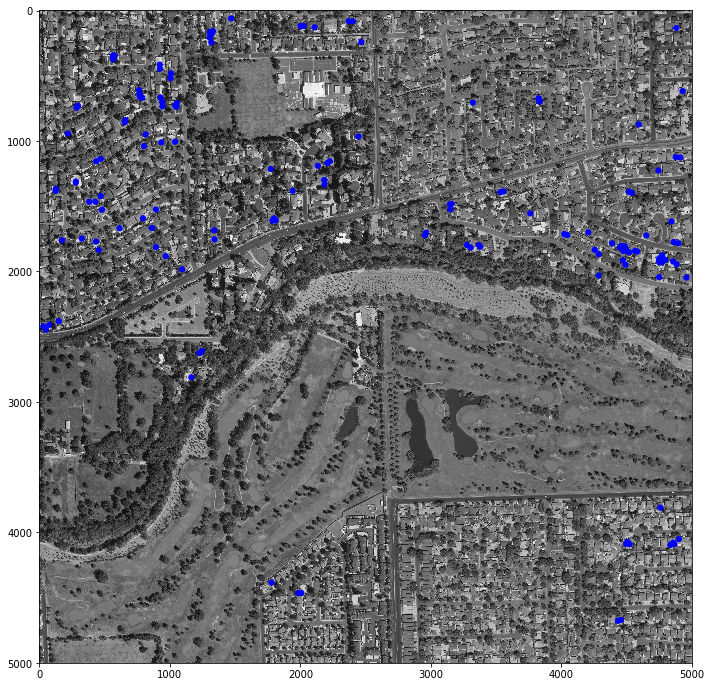

In [109]:
plot_centroids('10sfg810685')